In [1]:
import pandas as pd
import covasim as cv

from util import comb

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


# Covasim

## Simulator

Covasim is a **stochastic agent-based simulator** for performing COVID-19 analyses. These include projections of indicators such as numbers of infections and peak hospital demand. It can also be used to explore the potential impact of different interventions, including social distancing, school closures, testing, contact tracing, quarantine, and vaccination.

The scientific paper describing Covasim is available at http://paper.covasim.org.

## Running a Simulation

Running simulations in Covasim can be done using the `cv.Sim()` command, which accepts a dictionary of simulation parameters. The most common parameters to modify are the population size, the initial number of people infected, and the start and end dates of the simulation. The comprehensive list of parameters is available [here](https://docs.idmod.org/projects/covasim/en/latest/parameters.html).

Here, we fix the population size to `10000` and we use the `hybrid` population type, which guarantees the best trade-off between computational cost and realistic interaction among agents.

In [2]:
pars = dict(
  pop_type='hybrid',
  pop_size=10000
)

sim = cv.Sim(pars)

These are the default values of some parameters which may be of interest.

In [3]:
parameters = [
 'beta',         # beta per symptomatic contact
 'contacts',     # the number of contacts per layer
 'dynam_layer',  # which layers are dynamic
 'beta_layer',   # transmissibility per layer
 'n_imports',    # average daily number of imported cases (actual number is drawn from Poisson distribution)
 'asymp_factor', # multiply beta by this factor for asymptomatic cases; no statistically significant difference in transmissibility
 'iso_factor',   # multiply beta by this factor for diagnosed cases to represent isolation
 'quar_factor',  # quarantine multiplier on transmissibility and susceptibility
 'quar_period'   # number of days to quarantine for
]

for key in parameters:
  print(f'{key:13} --> {sim[key]}')

beta          --> 0.016
contacts      --> {'h': 2.0, 's': 20, 'w': 16, 'c': 20}
dynam_layer   --> {'h': 0, 's': 0, 'w': 0, 'c': 0}
beta_layer    --> {'h': 3.0, 's': 0.6, 'w': 0.6, 'c': 0.3}
n_imports     --> 0
asymp_factor  --> 1.0
iso_factor    --> {'h': 0.3, 's': 0.1, 'w': 0.1, 'c': 0.1}
quar_factor   --> {'h': 0.6, 's': 0.2, 'w': 0.2, 'c': 0.2}
quar_period   --> 14


The execution of a simulation produces the following results:

In [4]:
sim.run();

Initializing sim with 10000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.60 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.69 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.79 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.92 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (1.02 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (1.19 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (1.34 s)  •••••••••••••••••••• 100%

Simulation summary:
    6342 cumulative infections
    5377 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
    3066 cumulative recoveries
    3494 cumulative symptomatic cases
     205 cumulative severe cases
      49 cumulative critical cases
       9 cumulative deaths
       0 cumulative quarantined people



## Running multiple simulations

As we are aiming to use Covasim to generate realistic data, we will need to run more than one simulation simultaneously. The most common way to run multiple simulations is with the `MultiSim` object. As the name suggests, this is a relatively simple container for a number of sims. However, it contains powerful methods for plotting, statistics, and running all the sims in parallel.

In [5]:
multi_pars = [ (k, v) for k, v in dict(
  rand_seed = range(3),
  beta = [0.01, 0.02, 0.03]
).items()]

multi_pars

[('rand_seed', range(0, 3)), ('beta', [0.01, 0.02, 0.03])]

We rely on our utility function `cartesian_product` to generate a list of python dictionaries containing all the possible combinations of the parameters that we are willing to explore. In the end, the total number of configurations will be given by the product of the number of values which can be assumed by each variable parameter. E.g., in this case, we have three possible values for `rand_seed` and three possible values for `beta`, for a total of $3 \cdot 3 = 9$ configurations.

In [6]:
fixed_pars = dict(
  pop_type='hybrid',
  location='italy',
  pop_size=10000,
  n_days=90,
  verbose=0
)

pars_list = comb.cartesian_product(multi_pars, fixed_pars)
len(pars_list)

9

We can now map each configuration into a Covasim `Sim` object, and then create and run the `MultiSim`.

In [7]:
sims = [cv.Sim(pars, label=f'Sim {i}') for i, pars in enumerate(pars_list)]
msim = cv.MultiSim(sims)
msim.brief()

MultiSim(n_sims: 9; base: Sim("Sim 0"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run))


In [8]:
%%time
msim.run()

CPU times: user 111 ms, sys: 45.9 ms, total: 157 ms
Wall time: 7.66 s


# Interventions

## Purpose

It is possible to modify the parameters of the simulation during the execution via a set of explicit rules. This can come handy to reproduce the effect of the adopted countermeasures.
We have decided to cover the following interventions: number of tests, contact tracing, lockdown, smart working, schools closed, imported cases, viral load.
In order to have a deeper knowledge about the effect of each of them, let's see what is their effect on a simulation.

In [9]:
def interventions_effect(interventions, label="Intervention"):
    sim_base = cv.Sim(fixed_pars, label="Base")
    sim_tests = cv.Sim(fixed_pars, interventions=interventions, label=label)
    msim = cv.MultiSim([sim_base, sim_tests])
    msim.run()
    return msim

## Tests

Performing tests on the population can be helpful to detect infected people and isolate them as soon as possible.

In [10]:
tests = cv.test_num(daily_tests=40, quar_policy='both', sensitivity=0.8, do_plot=False)
msim = interventions_effect(interventions=tests, label="Tests")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 7862⚙, 66☠)
    1: Sim("Tests"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 6496⚙, 47☠)



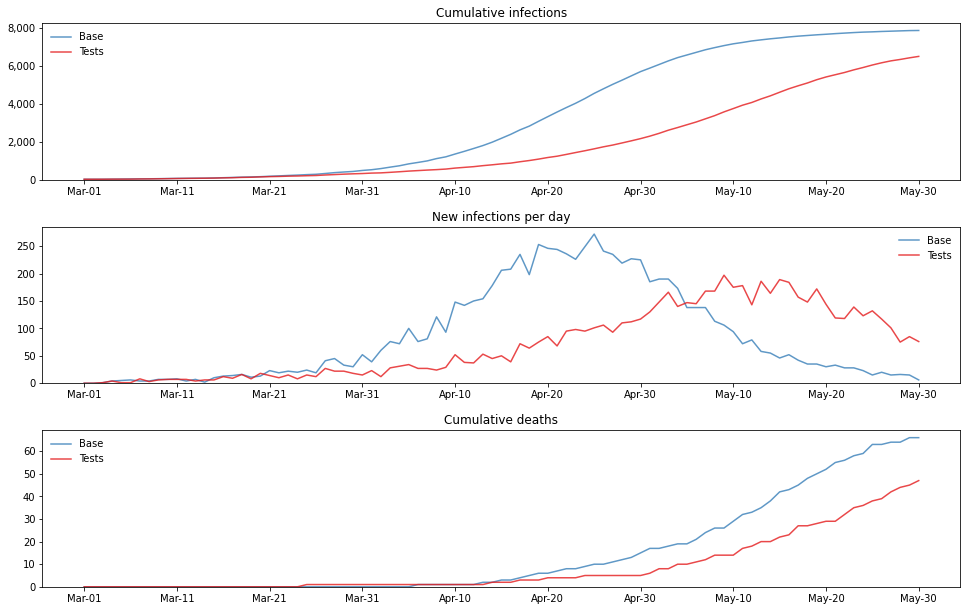

In [11]:
msim.plot(fig_args={"figsize": (15, 9)});

## Contact Tracing

When a person is diagnosed positive by a test, a certain proportion (`trace_prob`) of people in contact with him is contacted within a certain number of days (`trace_time`) to be placed into quarantine.

In [12]:
contact_tracing = cv.contact_tracing(trace_probs=0.25, trace_time=4)
msim = interventions_effect(interventions=[tests, contact_tracing], label="Contact Tracing")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 7862⚙, 66☠)
    1: Sim("Contact Tracing"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 3373⚙, 30☠)



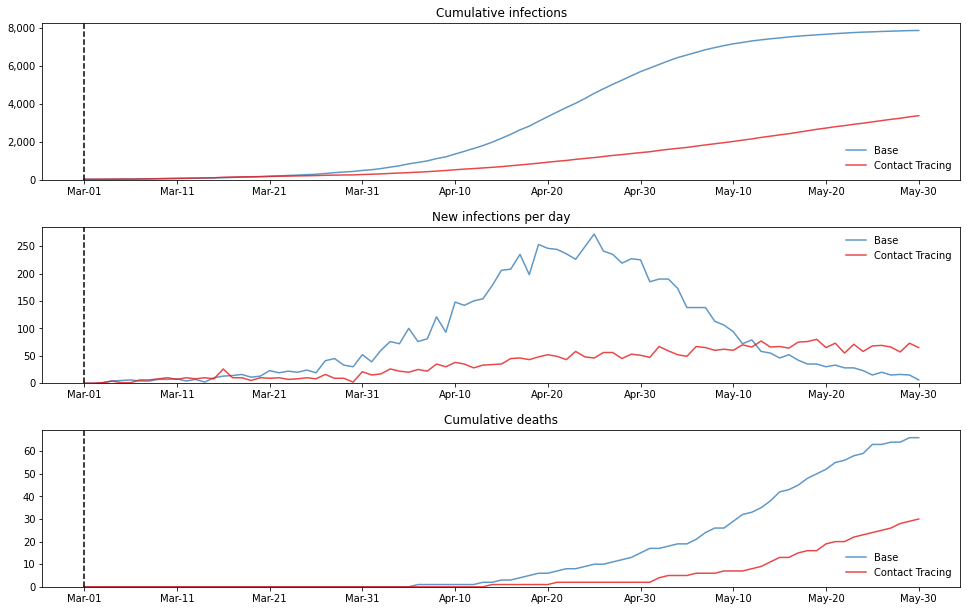

In [13]:
msim.plot(fig_args={"figsize": (15, 9)});

## Lockdown, Smart Working, Schools Closed

All these measures have the effect of reducing the number of contacts between people, the main difference is the simulation layer they act upon (respectively `c`, `w`, and `s`).
You must specify the days in which the measure starts (`days`), and, for each of them, the new percentage of contacts (`changes`) in introduces.

In [14]:
contacts = cv.clip_edges(days=[60, 80], changes=[0.3, 1.0])
msim = interventions_effect(interventions=contacts, label="Reduce Contacts")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 7862⚙, 66☠)
    1: Sim("Reduce Contacts"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 6171⚙, 58☠)



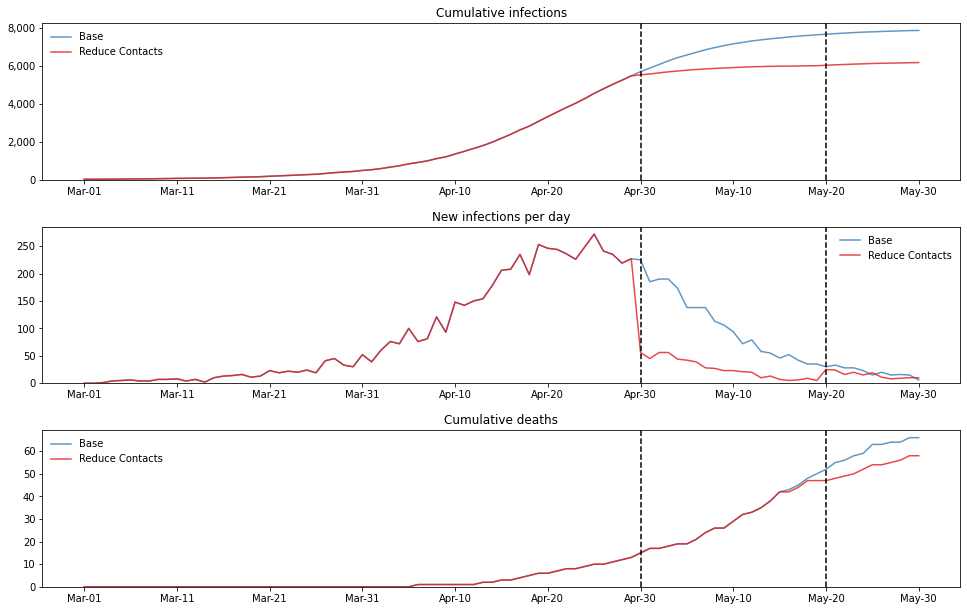

In [15]:
msim.plot(fig_args={"figsize": (15, 9)});

## Imported Cases

Infected people can spontaneously arise without an actual infection happens in the simulation. It is the case, for instance, of people coming from outside the selected location.

In [16]:
imports = cv.dynamic_pars(n_imports=dict(days=20, vals=100))
msim = interventions_effect(interventions=imports, label="Imports")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 7862⚙, 66☠)
    1: Sim("Imports"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 9164⚙, 117☠)



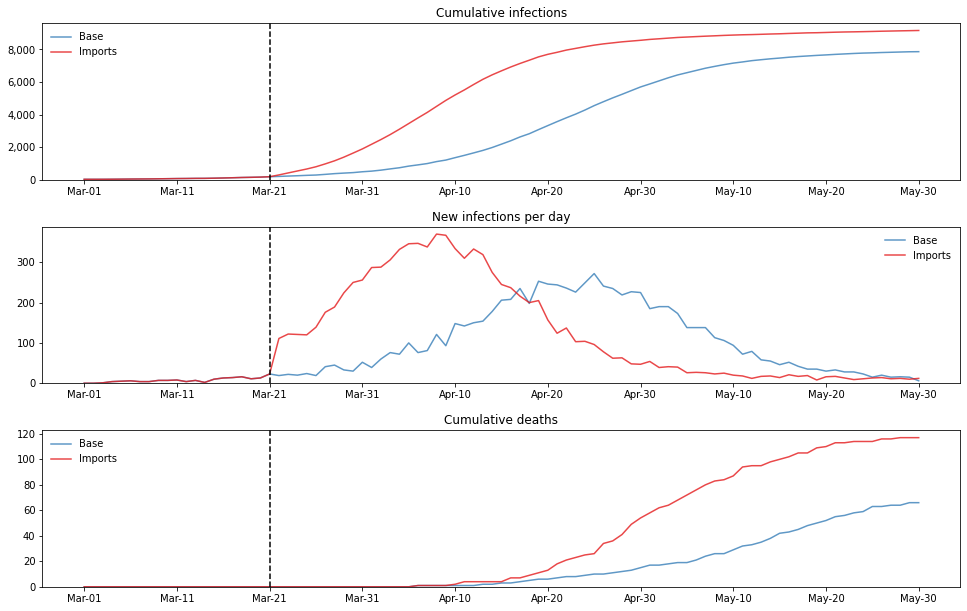

In [17]:
msim.plot(fig_args={"figsize": (15, 9)});

## Viral Load

While `clip_edges` is designed to reduce the number of social contacts specifically, `chenge_beta` is more general and covers all the aspects that may affect the transmission rate of the virus (e.g., hand washing, masks, temperature, etc).

In [18]:
beta = cv.change_beta(days=[60, 80], changes=[0.3, 1.0])
msim = interventions_effect(interventions=beta, label="Beta Change")
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 7862⚙, 66☠)
    1: Sim("Beta Change"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 6304⚙, 59☠)



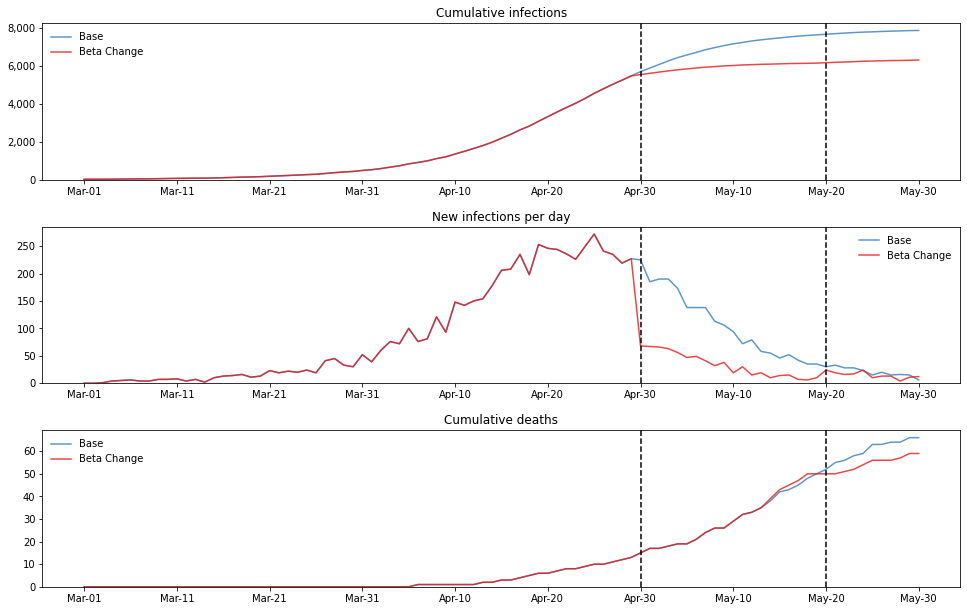

In [19]:
msim.plot(fig_args={"figsize": (15, 9)});